# NLP GD-08 Seq2seq으로 번역기 만들기

### 2023-01-27(금)


## 한글 폰트 설정

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

완료!


## 모듈 임포트

In [2]:
import time
import re
import os
import io

import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import pandas as pd

print(pd.__version__)
print(tf.__version__)
print(matplotlib.__version__)

1.3.3
2.6.0
3.4.3


## Step 1. 데이터 다운로드

In [3]:
path_to_zip = tf.keras.utils.get_file(
    'korean-english-park.train.tar',
    origin = 'https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz',
    extract=True,
    archive_format='tar') # format 'tar' can also unzip tar.gz file

eng_path_to_file = os.path.dirname(path_to_zip) + '/korean-english-park.train.en'
kor_path_to_file = os.path.dirname(path_to_zip) + '/korean-english-park.train.ko'

8732672/8718893 [==============================] - 0s 0us/step


### 한글 데이타 살펴보기

In [4]:
with open(kor_path_to_file, "r") as f:
    ko_raw = f.read().splitlines()

print("Data Size:", len(ko_raw))
print("Example:")

for sen in ko_raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


### 영문 데이타 살펴보기

In [5]:
with open(eng_path_to_file, "r") as f:
    eng_raw = f.read().splitlines() # line 별로 split

print("Data Size:", len(eng_raw))
print("Example:")

for sen in eng_raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


## Step 2. 데이터 정제

In [6]:
cleaned_corpus = [] # concatenate both corpus into one

for i in range(len(eng_raw)) :
    cleaned_corpus.append(eng_raw[i] +'\t'+ ko_raw[i]) # eng + \t + kor

### 중복 데이타 제거

In [7]:
len(cleaned_corpus)

94123

In [8]:
#세트로 중복 제거
cleaned_corpus = set(cleaned_corpus)

In [9]:
len(cleaned_corpus)

78968

### 데이타 전처리

In [10]:
from konlpy.tag import Mecab
mecab = Mecab()

def preprocess_sentence(sentence, s_token=False, e_token=False, kor=False):
    if kor :
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence) 
        sentence = re.sub(r"[^ㄱ-ㅎ가-힣?.!,]+", " ", sentence)
        mecab = Mecab()
        sentence = mecab.morphs(sentence)
        sentence = ' '.join(sentence)

    else :
        sentence = sentence.lower().strip()
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

        sentence = sentence.strip()

        if s_token:
            sentence = '<start> ' + sentence

        if e_token:
            sentence += ' <end>'
            
#         sentence = sentence.split()
    
    return sentence

### 코퍼스 생성

In [11]:
enc_corpus = []
dec_corpus = []
num_examples = 30000

for sentence in list(cleaned_corpus)[: num_examples]:
    eng, kor = sentence.split('\t')
    
    kor = preprocess_sentence(kor, kor = True)
    eng = preprocess_sentence(eng, s_token=True, e_token=True)
    
    # 한글은 mecab, 영문은 split()
    if len(mecab.morphs(kor)) < 50 and len(eng.split()) < 50 : # token size limit to less than 40, eng 40 + 2 sp tkn
        enc_corpus.append(kor) # 한글 정처리 후 코퍼스에 추가
        dec_corpus.append(eng) # 영문 전처리 후 코퍼스에 추가

In [12]:
print(len(enc_corpus))    # 한글 코퍼스
print(len(enc_corpus[0])) # 코퍼스[0] : 문장

print(len(dec_corpus))    # 영문 코퍼스 
print(len(dec_corpus[0])) # 코퍼스[0] : 문장

27972
44
27972
86


In [13]:
print('Korean: ',enc_corpus[0])  #
print('English: ',dec_corpus[0]) # 

Korean:  총 회의 폭발 이 일어나 최소 명 이 숨지 고 수백 명 이 부상 당했 습니다 .
English:  <start> thirteen blasts in all , killing at least people and injuring hundreds . <end>


### 문장 최대 길이 구하기

In [14]:
def find_maxlen(corpus, kor = False) : 
    '''
    returns the max number of token(seq) and the index corresponding to it
    '''
    max_len = 0
    idx = 0
    
    for i,sen in enumerate(corpus) :
        if kor :
            length = len(mecab.morphs(sen))
            if max_len < length : 
                max_len = length
                idx = i
        else :
            length = len(sen.split())
            if max_len < length : 
                max_len = length
                idx = i
                
    return max_len,idx

In [15]:
print('encoder max_seq:' , find_maxlen(enc_corpus, kor=True))
print('decoder max_seq:' , find_maxlen(dec_corpus))

encoder max_seq: (49, 128)
decoder max_seq: (49, 273)


## Step 3. 데이터 토큰화

In [16]:
enc_corpus[0]

'총 회의 폭발 이 일어나 최소 명 이 숨지 고 수백 명 이 부상 당했 습니다 .'

### 토크화 함수 정의

In [17]:
# tokenize function using keras

def tokenize(corpus, kor = False):
    if kor : # 한글의 토큰화
        mecab = Mecab()
        sentence = []
        
        # 한글은 형태소 분석을 통한 분해를 실시
        for sen in corpus :
            sentence.append(mecab.morphs(sen))
        
        # 케라스 토크나이저를 사용
        tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 20000, filters='')
        tokenizer.fit_on_texts(sentence)
        
        # 토큰화 실시
        tensor = tokenizer.texts_to_sequences(corpus)
        
        # 패딩
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
            
    else : # 영어의 토큰화
        # 영문은 직접 케라스 토크나이저에 넣음
        tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 20000, filters='')
        tokenizer.fit_on_texts(corpus)
        
        # 토큰화 실시
        tensor = tokenizer.texts_to_sequences(corpus)
        
        # 패딩
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

### 토큰화 실시

In [18]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(enc_corpus, kor=True)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 28145
English Vocab Size: 29490


### 토큰화 결과 보기

#### 인코딩 텐서

In [19]:
enc_tensor[0]

array([ 455,  374,  447,    3, 1224,  540,   31,    3, 1325,   12,  977,
         31,    3,  265,  809,   59,    1,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [20]:
for i in enc_tensor[0] :
    if i != 0:
        print(enc_tokenizer.index_word[i], end = ' ')

총 회의 폭발 이 일어나 최소 명 이 숨지 고 수백 명 이 부상 당했 습니다 . 

#### 디코딩 텐서

In [21]:
dec_tensor[0]

array([    4, 12909,  3296,     9,    74,     3,   420,    20,   175,
          42,    10,  3586,   539,     2,     5,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0], dtype=int32)

In [22]:
for i in dec_tensor[0] :
    if i != 0:
        print(dec_tokenizer.index_word[i], end = ' ')

<start> thirteen blasts in all , killing at least people and injuring hundreds . <end> 

## 모델용 레이어 설계

### 바다나우 어텐션 레이어 (Bahdanau Attention)

In [23]:
# 바다나우 어텐션 레이어
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

### 인코더 레이어

In [24]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):           # 인코더
        out = self.embedding(x)  #  - (인코더) 임베딩
        out = self.gru(out)      #  - GRU 
        
        return out

### 디코더 레이어

In [25]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.dropout = tf.keras.layers.Dropout(0.5) # addd dropout layer
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):                                     # 디코더
        context_vec, attn = self.attention(enc_out, h_dec)                 #  - 어텐션 레이어 -> 컨텍스트, 어텐션
        out = self.embedding(x)                                            #  - (디코더) 임베딩
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)    #  - Concat() : 컨텍스트 + 임베딩        
        out, h_dec = self.gru(out)                                         #  - GRU  
        out = self.dropout(out)                                            #  - Dropout 
        out = tf.reshape(out, (-1, out.shape[2]))                          #  - reshape : Vocab size에 맞춤 
        out = self.fc(out)                                                 #  - FC 

        return out, h_dec, attn

## 모델 정의

### 하이퍼파라미터 설정

In [26]:
# hyperparameter

BATCH_SIZE     = 64
LEARNING_RATE = 1e-3
EPOCHS = 30

#### Vocab 크기

In [27]:
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1 # add 1 for padding 
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1 # add 1 for padding 

#### 임베딩 크기

In [28]:
units         = 512 #dimension for gru
embedding_dim = 512 # dimension for embedding

#### 인코더

In [29]:
encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)

#### 디코더

In [30]:
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

### 옵티마이저

In [31]:
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


### 손실함수 정의

In [32]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

## 모델 훈련

### 훈련함수 정의 : 그래디언트 테이프용

In [33]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

### 훈련 루프

In [34]:
from tqdm import tqdm    # tqdm
import random

for epoch in range(EPOCHS): # EPOCHS 하이퍼파라미터 설정부에 정의
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE)) # BATCH_SIZE 하이퍼파라미터 설정부에 정의
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 30: 100%|██████████| 438/438 [02:19<00:00,  3.14it/s, Loss 0.5270]


## 모델 평가

In [35]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    sentence = preprocess_sentence(sentence, kor =True) # kor True 
    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

## 모델 테스트

In [36]:
test_corpus = ['오바마는 대통령이다.','시민들은 도시 속에 산다.','커피는 필요 없다.','일곱 명의 사망자가 발생했다.']

Input: 오바마 는 대통령 이 다 .
Predicted translation: obama is a congressman , the illinois president is the president is the president is the president is the president is the president is the president is the president is the president is the president is the president is the president is the president is the president is the 


/tmp/ipykernel_31/1801226307.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_31/1801226307.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


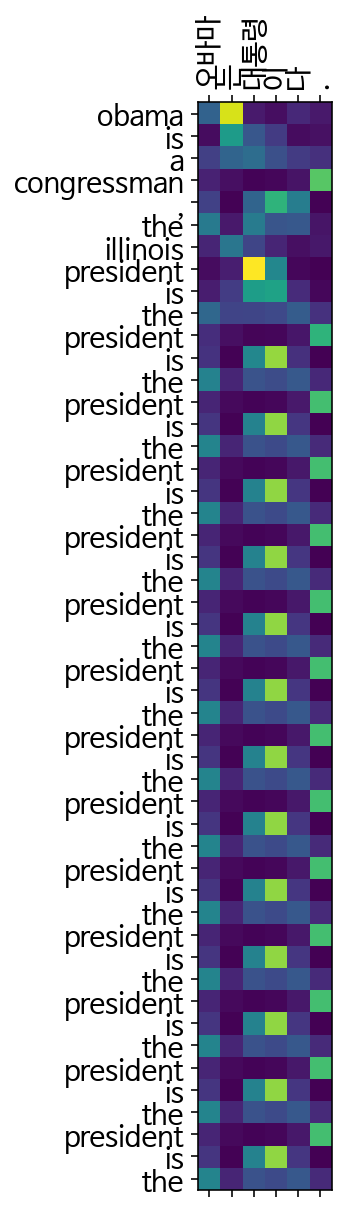

Input: 시민 들 은 도시 속 에 산다 .
Predicted translation: many people are on the streets . <end> 


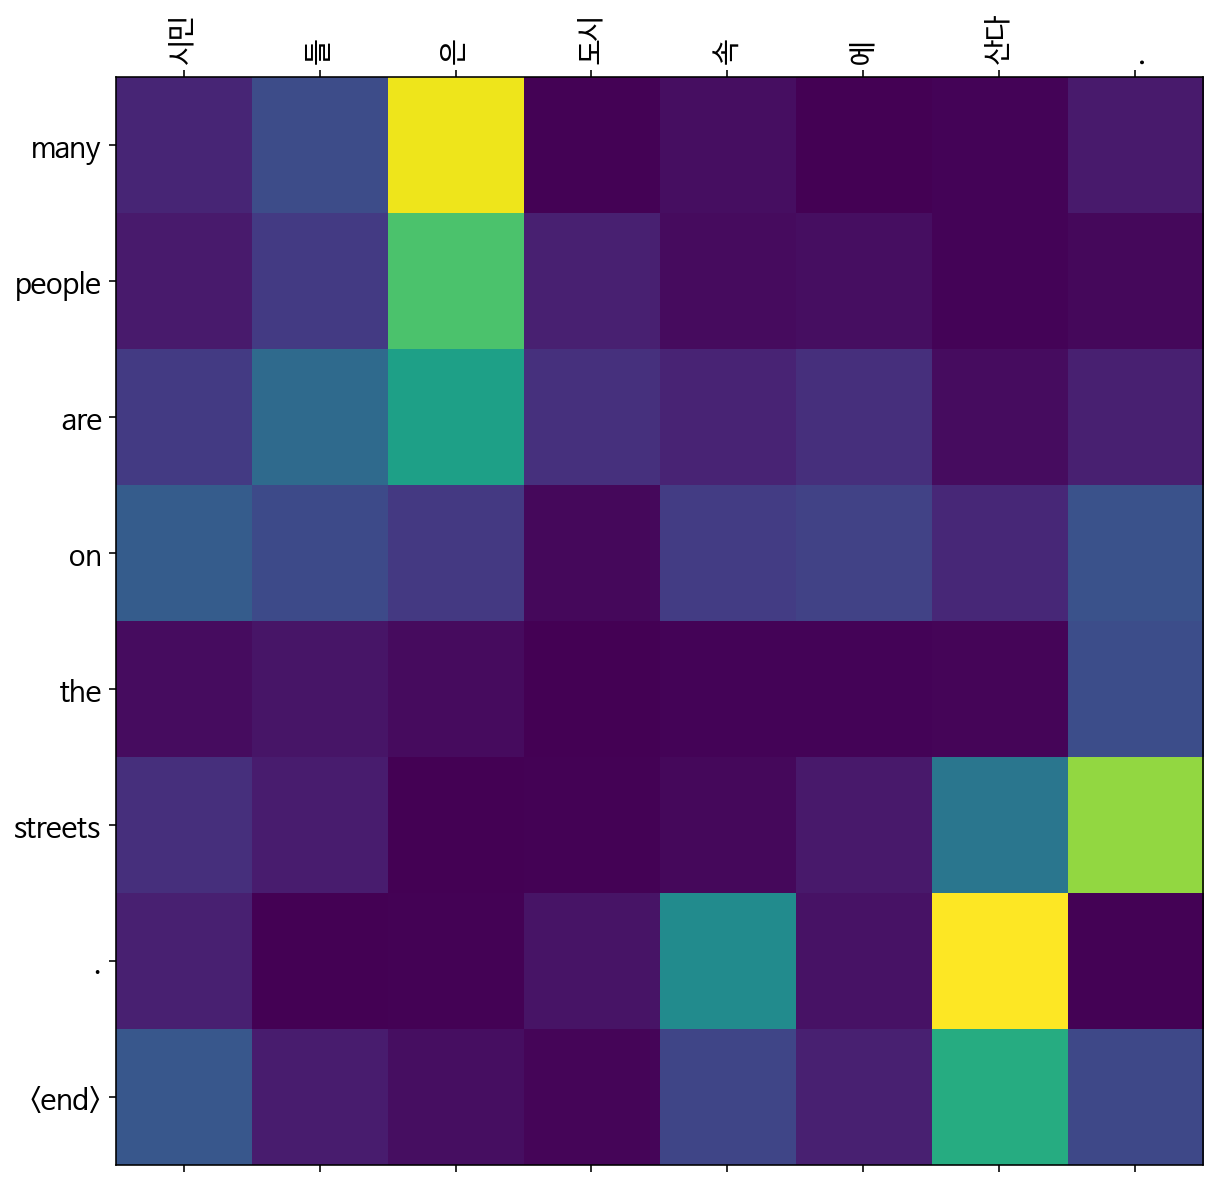

Input: 커피 는 필요 없 다 .
Predicted translation: the instruments will be a good . <end> 


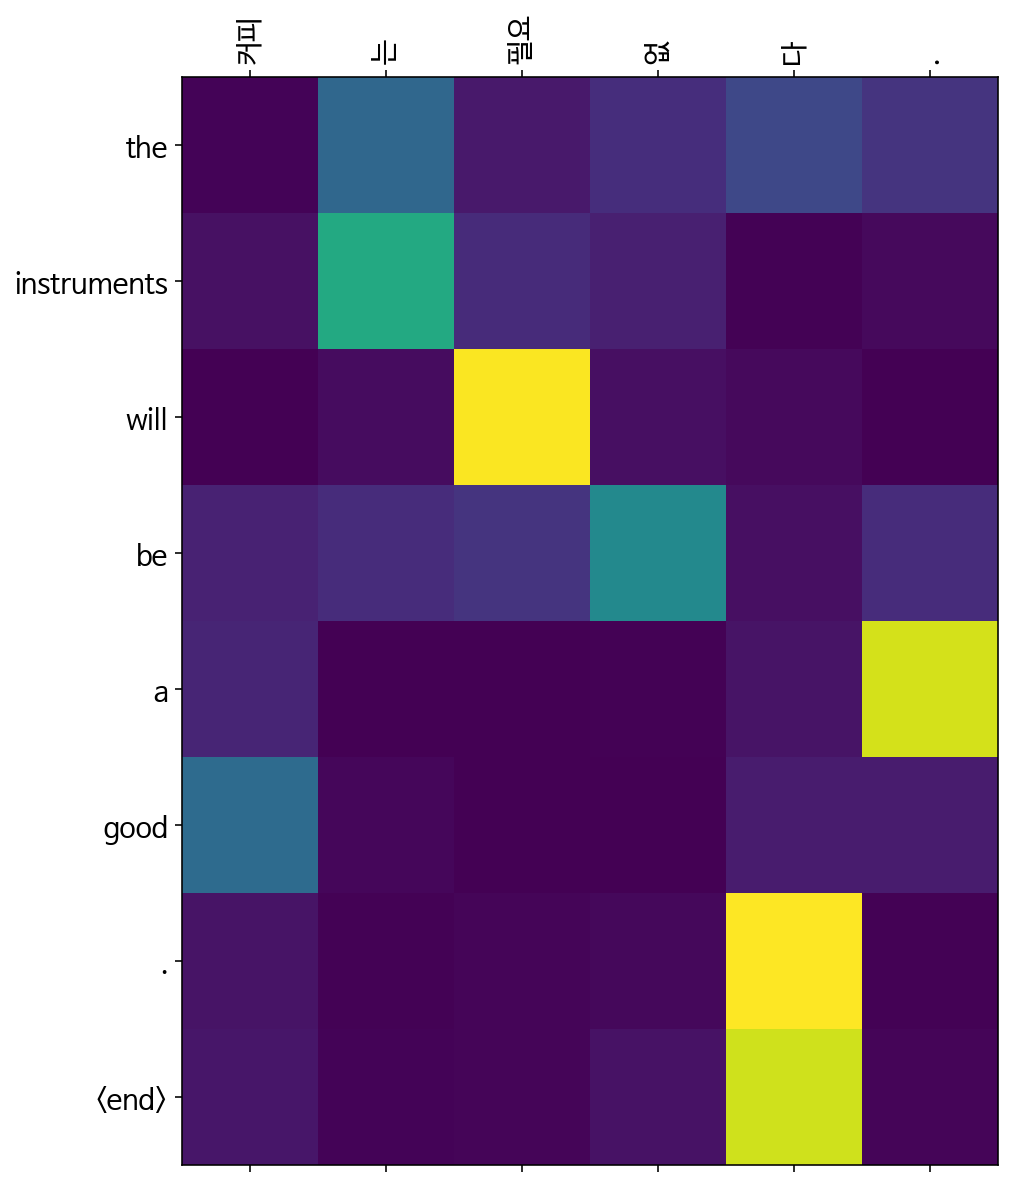

Input: 일곱 명 의 사망자 가 발생 했 다 .
Predicted translation: two of the deaths were injured . <end> 


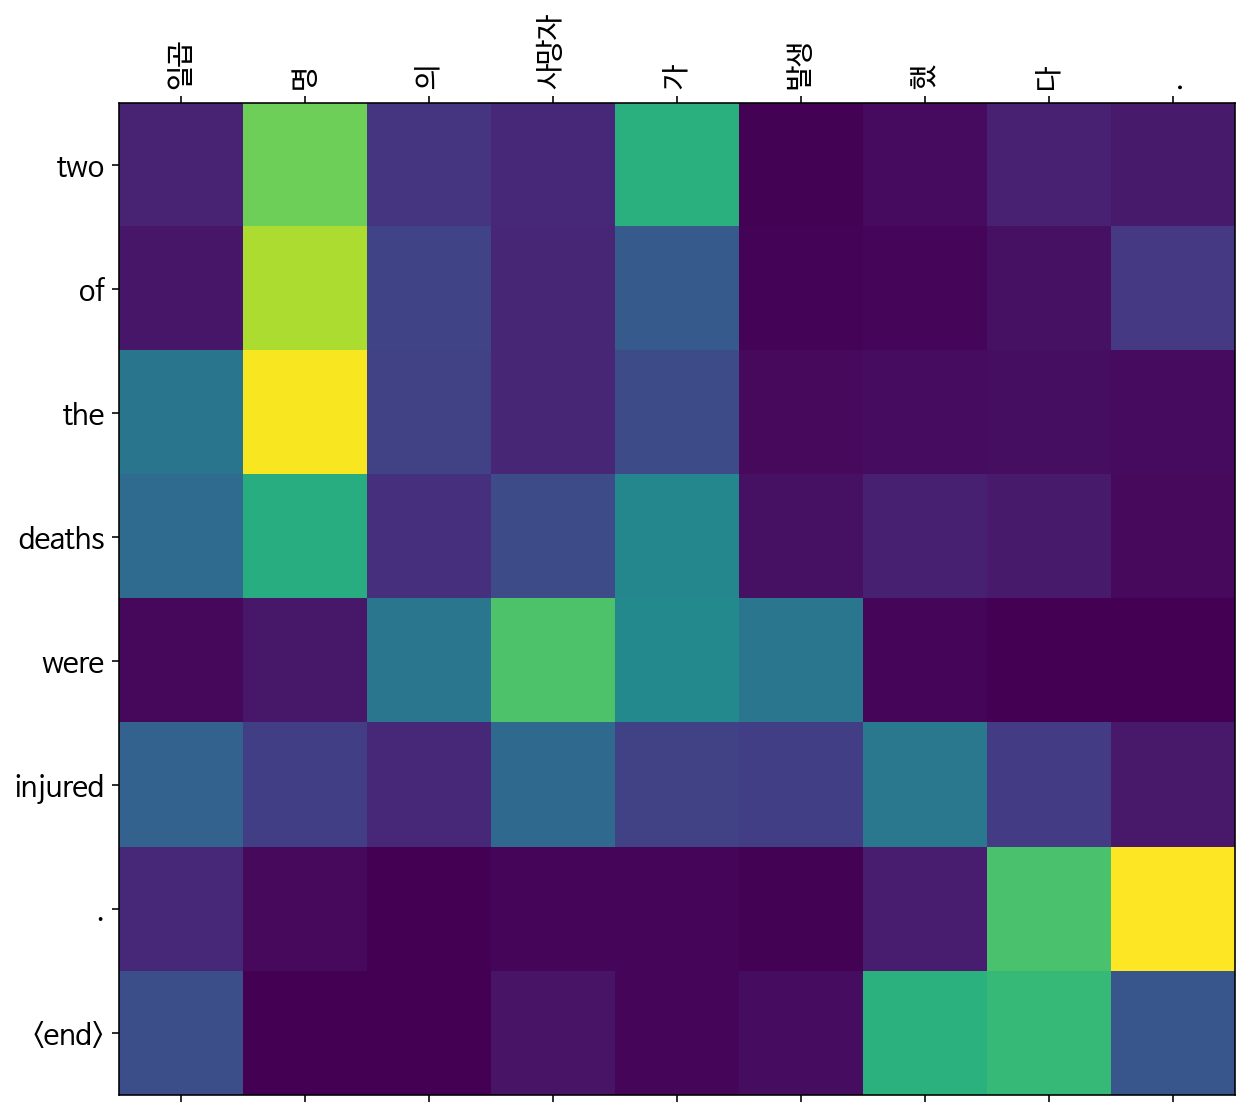

In [37]:
for i in test_corpus :
    translate(i, encoder, decoder) 

### 고찰

1. 한글과 영어의 경우 전처리 및 토크나이징 과정에 나타나는 차이를 이해라 수 있었다. 한글의 경우 전처리 및 토큰화 과정에서 Mecab 등 형태소 분석기를 통해 subword 단위로 토큰을 아눈 과정이 별도로 필요했다. 영어의 경우에는 케라스 토크나이저를 통해 이렁 과정 없이 바로 토튼화를 진행할 수 있었다. 여러 차례의 프로젝트를 통해 한글 토크나이징 과정을 좀 더 이해할 수 있었다.

2. Vocab size의 변화(30K, 40K, 50K) 또는 최대 시퀀스 길이 (40, 50, 100, 200)에 따라 학습 시간이 매우 길어지기도 했거, 메모리의 사용량이 크게 차이가 났으며, 일부 큰 모델을 선택하면 학습 중 시스템이 중단되기도 했다. 좋은 성능을 얻기 위해서는 데이타의 양도 중요하지만 컴퓨팅 자원의 확보 여부도 함께 고려해야 할 것 같다.

3. 여러 파라미터를 조정했으나 제대로 된 결과를 얻기에는 부족했다.

